# Analyse Stores in Transactions

In [2]:
# Import der notwendigen Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Konfiguration
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

stores = pd.read_csv("data/stores.csv")
transactions = pd.read_parquet("data/transactions_train_1.parquet")
transactions_test = pd.read_parquet("data/transactions_test_1.parquet")


In [3]:

print(stores.columns) 

Index(['id', 'opening_date', 'location', 'state', 'urbanization',
       'sco_introduction'],
      dtype='object')


In [4]:
print("🔹 Erste Zeilen des Datensatzes:")
display(transactions.head())

🔹 Erste Zeilen des Datensatzes:


,id,store_id,cash_desk,transaction_start,transaction_end,total_amount,n_lines,payment_medium,customer_feedback,damage,label
0,5bedf771-f016-41a7-ab89-f40e7f6be955,b0973ffa-ce15-41e0-9de7-1390598e24f2,0,2022-02-02 08:00:12,2022-02-02 08:01:02.825563,52.26,6,CREDIT_CARD,NaN,NaN,UNKNOWN
1,21ff1406-dbc4-41a7-8429-836cbf96d853,b0973ffa-ce15-41e0-9de7-1390598e24f2,1,2022-02-02 08:05:06,2022-02-02 08:05:30.565876,1.47,1,CREDIT_CARD,NaN,NaN,UNKNOWN
2,b642f9b6-43b5-413d-ad08-b4bf4b664b52,b0973ffa-ce15-41e0-9de7-1390598e24f2,2,2022-02-02 08:07:12,2022-02-02 08:11:29.434607,363.87,37,CREDIT_CARD,NaN,0.0,NORMAL
3,16aa01c9-9678-4c6d-a007-baa3429b9fb8,b0973ffa-ce15-41e0-9de7-1390598e24f2,3,2022-02-02 08:11:45,2022-02-02 08:12:07.881710,3.43,1,CREDIT_CARD,NaN,NaN,UNKNOWN
4,0add22e5-6794-4e95-9d25-a1cd6b6cd083,b0973ffa-ce15-41e0-9de7-1390598e24f2,0,2022-02-02 08:15:15,2022-02-02 08:19:30.611551,441.40,47,CREDIT_CARD,NaN,NaN,UNKNOWN


In [5]:

print(transactions.columns)

Index(['id', 'store_id', 'cash_desk', 'transaction_start', 'transaction_end',
       'total_amount', 'n_lines', 'payment_medium', 'customer_feedback',
       'damage', 'label'],
      dtype='object')


## Join stores und transactions

Schlüsselattributs zur besseren Lesbarkeit umbenennen

In [6]:
stores.rename(columns={"id": "store_id"}, inplace=True)

Join

In [7]:
joined_df = transactions.merge(stores, on="store_id", how="left")

Welche Stores tauchen tatsächlich in Transaktionen auf?

In [8]:
# Alle Store-IDs mit mindestens einer Transaktion
stores_with_tx = transactions["store_id"].unique()

# Anzahl der betroffenen Stores
print(f"Anzahl Stores mit Transaktionen: {len(stores_with_tx)}")


Anzahl Stores mit Transaktionen: 3


Plausibilität prüfen

In [9]:
# Stores ohne Transaktionen herausfiltern
stores_without_tx = stores[~stores["store_id"].isin(stores_with_tx)]

# Anzahl der betroffenen Stores
print(f"Anzahl Stores ohne Transaktionen: {len(stores_without_tx)}")

Anzahl Stores ohne Transaktionen: 15


Betreffende Stores anzeigen

In [10]:
# Auswahl der gewünschten Spalten aus den betroffenen Stores
store_info = stores[stores["store_id"].isin(stores_with_tx)][["store_id", "opening_date", "location"]]

print(store_info)

                               store_id opening_date location
2  b0973ffa-ce15-41e0-9de7-1390598e24f2   2005-06-02   Berlin
4  d3892a9e-8cbc-4237-be9c-211435dc92c0   2003-02-10  München
9  ed996b17-17d6-47e8-9262-d1d02b52cdb4   1994-09-19  München


--> Nur die Stores in München und Berlin tauchen tatsächlich in den Transaktionen auf. Daher sind die übrigen Städte unnötig und können gelöscht werden.

Transactions ohne Store?

In [11]:
fehlende_stores = joined_df["opening_date"].isnull().sum()
print(f"Anzahl Transaktionen ohne zugeordneten Store: {fehlende_stores}")

Anzahl Transaktionen ohne zugeordneten Store: 0


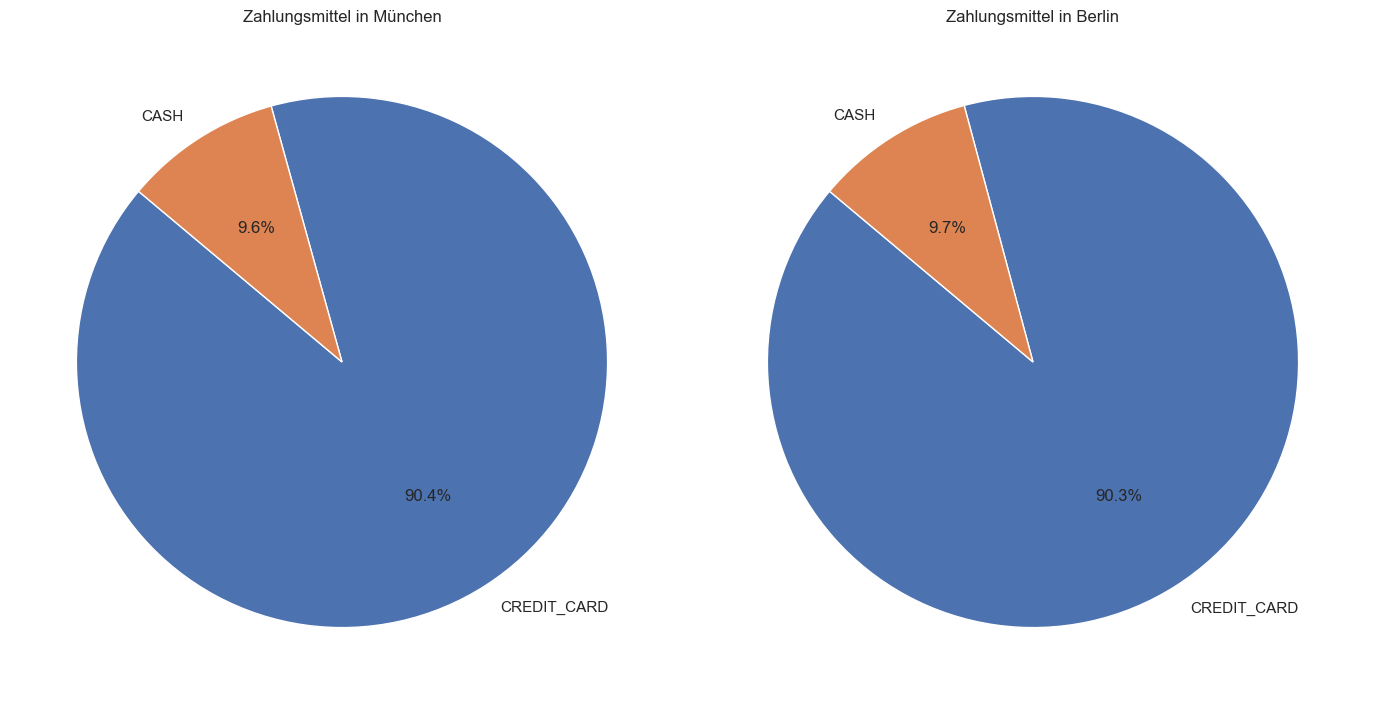

In [12]:
import matplotlib.pyplot as plt
# Schritt 1: Städte filtern – je nach store_id-Struktur anpassen!
joined_df["city"] = joined_df["store_id"].str.extract(r'(^[A-Z]{3})')  # z. B. 'MUC', 'BER'

# Schritt 2: Daten für München und Berlin vorbereiten
payment_munich = joined_df[joined_df["location"] == "München"]["payment_medium"].value_counts()
payment_berlin = joined_df[joined_df["location"] == "Berlin"]["payment_medium"].value_counts()

# Schritt 3: Plot erstellen
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# München
axes[0].pie(payment_munich, labels=payment_munich.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title("Zahlungsmittel in München")

# Berlin
axes[1].pie(payment_berlin, labels=payment_berlin.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title("Zahlungsmittel in Berlin")

plt.tight_layout()
plt.show()

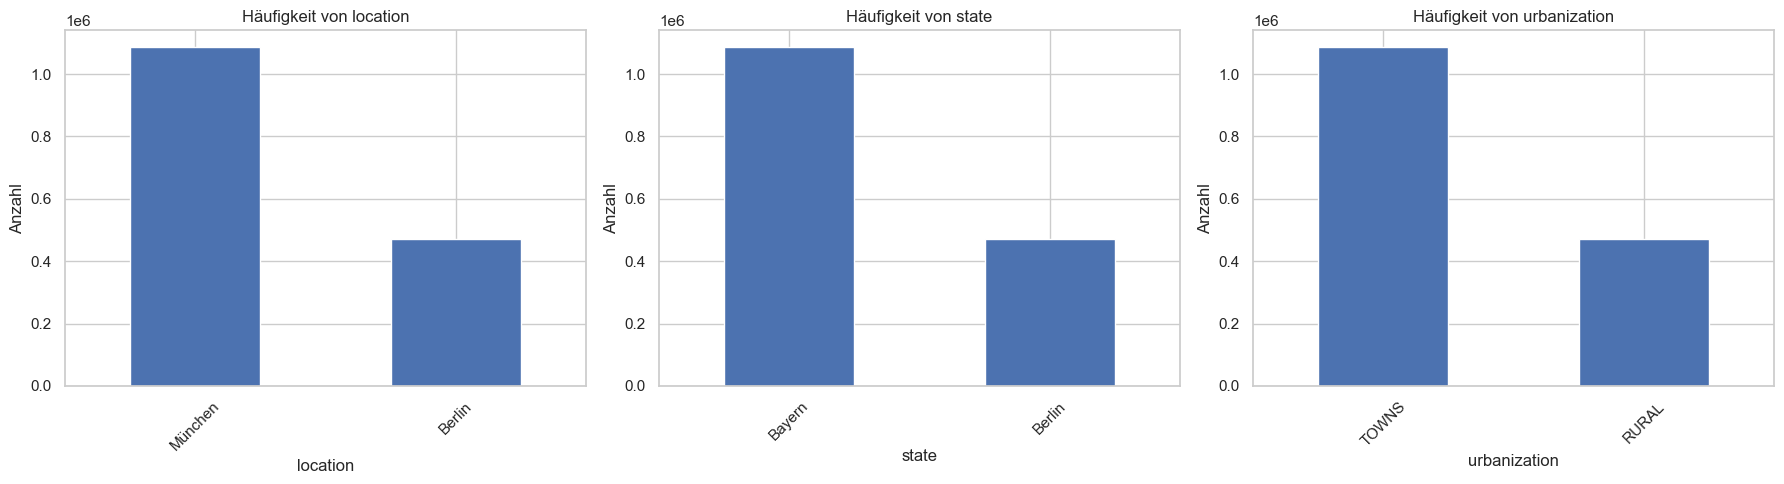

In [13]:
import matplotlib.pyplot as plt

# Liste der Spalten, die du analysieren möchtest
columns_to_plot = ['location', 'state', 'urbanization']

# Setze die Größe der gesamten Figure (3 Unterplots nebeneinander)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Für jede Spalte ein eigenes Balkendiagramm
for ax, col in zip(axes, columns_to_plot):
    joined_df[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(f'Häufigkeit von {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Anzahl')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
